Perform blocks in parallel:

    for site in sites:
        Download 5-minute data    
        Append data to regional dataframe
    With regional dataframe:
        Calculate sea-level-normalized temperature for each site
        Write sea-level-normalized temperature to dataframe

    Download elevation data
    With elevation data:
        With rasterio, load into raster
        Downscale as necessary
    
    Download RAP data (optional)


With elevation numpy array:  
    Create new np array with the same dimensions as the elevation data  
    Use a linear (or other) interpolation method on sea-level-normalized temperature at each pixel  
    Optionally correct/weight points far away from sensors with sea-level-normalized RAP data  
    Print numpy array to raster output (optional for debugging)  
    numpy array calculation; use sea-level temperature and altitude arrays to determine surface temperature at each pixel
    Print temperature array to raster output (final output)  
    Print an uncertainty array  
    Upload outputs to S3  
  
    
    
  

In [1]:
import json
import os
import urllib

from matplotlib import pyplot as plt
import metpy.calc
import numpy as np
import pandas as pd
import pint
import scipy.interpolate

from metpy.units import units
import rasterio

In [2]:
# Configuration
cwd = os.getcwd()

MESONET_DATA_URL = "http://xmountwashington.appspot.com/mmNew.php?callback=null"

TARGET_DEM_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/ArcGrid/USGS_NED_13_n45w072_ArcGrid.zip"
TARGET_DEM_FILE_ZIP = os.path.join(cwd, "tmp/dem.zip")
TARGET_DEM_FILE_UNZIP = os.path.join(cwd, "tmp/data/dem")
TARGET_DEM_DATA_FILE = os.path.join(TARGET_DEM_FILE_UNZIP, "grdn45w072_13", "w001001.adf")

# A ratio of number-of-datapoints-in-input-dem to number-of-datapoints-in-output-dem
OUTPUT_RESOLUTION = 1/10

In [3]:
def make_item(json):
    '''
    Takes a json object and creates an items' dataframe
    '''
    df = pd.DataFrame(columns=["siteName", "siteLat", "siteLon", "siteAltitude", "temperature", "potential_temperature"])
    for site in json:
        if "temperature" in json[site]:
            df = df.append({"siteName": site, 
                            "siteLat": json[site]["latitude"],
                            "siteLon": json[site]["longitude"],
                            "siteAltitude": units.meters,
                            "temperature": float(json[site]["temperature"]) * units.degF,
                            "potential_temperature": units.degF
                           }, 
                           ignore_index=True)
    populate_alt_from_dem(df)
    return df


def populate_alt_from_dem(df, file=TARGET_DEM_DATA_FILE):
    with rasterio.open(file) as dem:
        dem_arr = np.squeeze(dem.read())
        for i, row in df.iterrows():
            site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
            df.at[i, 'siteAltitude'] = dem_arr[site_y_pixel][site_x_pixel] * units.meters
    
    
def get_potential_temperature(df):
    for i, row in df.iterrows():
        if "pressure" not in row:
            pressure = metpy.calc.height_to_pressure_std(row["siteAltitude"])
        else:
            pressure = row["pressure"]
            
        if "dewpoint" in row:
            # calculate equivalent potential temperature
            potential_temperature = metpy.calc.equivalent_potential_temperature(pressure, row["temperature"], row["dewpoint"])
        else:
            # calculate potential temperature

            potential_temperature = metpy.calc.potential_temperature(pressure, row["temperature"])
        df.at[i,'potential_temperature'] = potential_temperature.to(units.degF)
        
            
# Should be as simple as pd.read_json once we figure out the callback issue
#pd.read_json('http://xmountwashington.appspot.com/mmNew.php')

In [4]:
import os
import urllib.request
import zipfile

def download_file(url, target, clobber=False):
    # TODO; move this to an S3 call
    make_dirs_if_no_exists(target)
    print("Downloading file %s" % url)
    if os.path.exists(target) and not clobber:
        print("Path %s already exists; using previoiusly downloaded file." % target)
        return False
    urllib.request.urlretrieve(url, target)  
    return True

        
def extract_file(source, target, delete_source=False):
    make_dirs_if_no_exists(target)
    print("Unzipping file %s to %s." % (source, target))
    with zipfile.ZipFile(source,"r") as zip_ref:
        zip_ref.extractall(target)
    

def make_dirs_if_no_exists(dirname):
    if not os.path.exists(os.path.dirname(dirname)):
        print("Path %s does not exist.  Attempting to make it now." % os.path.dirname(dirname))
        os.makedirs(os.path.dirname(dirname))

In [5]:
# Driver for download and extraction of DEM data
# Must occur first so altitude data can be determined in the mesonet dataframe

if download_file(TARGET_DEM_URL, TARGET_DEM_FILE_ZIP):
    extract_file(TARGET_DEM_FILE_ZIP, TARGET_DEM_FILE_UNZIP)

Path /external/mesonet-interpolation/temperature/tmp/dem.zip already exists; using previoiusly downloaded file.


In [6]:
# Driver for downloading mesonet data and performing point calculations

with urllib.request.urlopen(MESONET_DATA_URL) as response:
    callback = response.read()
json_string = callback.decode("utf8").rstrip(')').lstrip('null(')
mesonet_data = json.loads(json_string)
df = make_item(mesonet_data['currentMesonetConditions'])
get_potential_temperature(df)


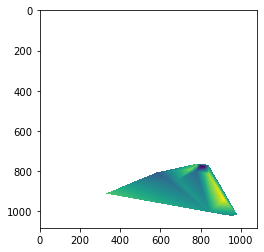

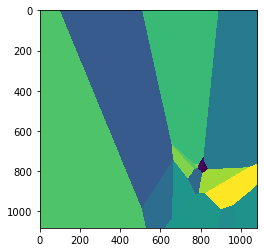

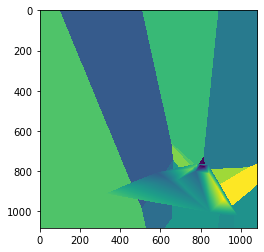

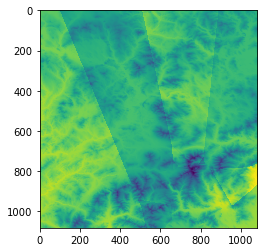

In [21]:
# Driver that combines mesonet and DEM data

with rasterio.open(TARGET_DEM_DATA_FILE) as dem:
    dem_arr = dem.read()
    
    output_res_step = int(1/OUTPUT_RESOLUTION)
    
    x = np.arange(0, dem.width, output_res_step)
    y = np.arange(0, dem.height, output_res_step)
    X, Y = np.meshgrid(x,y)
    
    dem_arr = np.squeeze(dem_arr)
    condensed_altitudes = dem_arr[0:dem.height:output_res_step, 0:dem.width:output_res_step]
    
    x_pixels = []
    y_pixels = []
    values = []
    
    for i, row in df.iterrows():
        site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
        x_pixels.append(site_x_pixel)
        y_pixels.append(site_y_pixel)
        values.append(row["potential_temperature"].magnitude)
    
    potential_temperature_interpolated_linear = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="linear")
    plt.imshow(potential_temperature_interpolated_linear)
    plt.show()
    potential_temperature_interpolated_nearest = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="nearest")
    potential_temperature_interpolated_linear[np.isnan(potential_temperature_interpolated_linear)] = potential_temperature_interpolated_nearest[np.isnan(potential_temperature_interpolated_linear)]
    plt.imshow(potential_temperature_interpolated_nearest)
    plt.show()
    plt.imshow(potential_temperature_interpolated_linear)
    plt.show()
    
    pressure = metpy.calc.height_to_pressure_std(condensed_altitudes * units.meters)
    temperature = metpy.calc.temperature_from_potential_temperature(pressure, potential_temperature_interpolated_linear * units.degF)
    plt.imshow(temperature)
    plt.show()
    

In [22]:
for i, row in df.iterrows():
    x_pixel_output = x_pixels[i] * OUTPUT_RESOLUTION
    y_pixel_output = y_pixels[i] * OUTPUT_RESOLUTION
    site_temperature_output = temperature[int(y_pixel_output), int(x_pixel_output)]
    temperature_diff = site_temperature_output.to(units.degF) - row["temperature"]
    print(temperature_diff)
        
print(np.min(temperature.to(units.degF)))
print(np.max(temperature.to(units.degF)))

0.03293910575332859 delta_degF
-0.33505234351170543 delta_degF
0.6930827374459057 delta_degF
0.22546444212446204 delta_degF
-0.2773017783176215 delta_degF
0.3327315576046814 delta_degF
0.29400697697568035 delta_degF
0.1886148681922748 delta_degF
0.13006211200897155 delta_degF
0.0886086780554507 delta_degF
0.10278236176510802 delta_degF
0.018356710821947786 delta_degF
-0.4771431916699811 delta_degF
0.18305222110626573 delta_degF
0.16693064505552968 delta_degF
-0.09011190974020167 delta_degF
0.06549761677780452 delta_degF
55.48061102530436 degF
90.7973656928776 degF
